In [1]:
from transformer_lens import HookedTransformer
import transformer_lens
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import transformer_lens.utils as utils
import hashlib
import yaml 
import hashlib
import pickle
import numpy as np
import matplotlib.pyplot as plt 

/root/mech_interp_research/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_grad_enabled(False)

In [3]:
device = utils.get_device()

reference_model_path = 'meta-llama/Llama-3.1-8B'
baseline_model_path = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

baseline_model_hf = AutoModelForCausalLM.from_pretrained(baseline_model_path, torch_dtype=torch.bfloat16)
baseline_model_tokenizer = AutoTokenizer.from_pretrained(baseline_model_path)

baseline_model = HookedTransformer.from_pretrained_no_processing(
    reference_model_path,
    hf_model=baseline_model_hf,
    tokenizer=baseline_model_tokenizer,
    device=device,
    move_to_device=True,
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.41it/s]


Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


In [4]:
model=baseline_model

In [5]:
chat = [
  {"role": "user", "content": "What's the fifth prime?"},
]

In [6]:
model.tokenizer.apply_chat_template(chat, add_generation_prompt=True, tokenize=False)

"<｜begin▁of▁sentence｜><｜User｜>What's the fifth prime?<｜Assistant｜><think>\n"

In [7]:
model.tokenizer.apply_chat_template(chat, add_generation_prompt=True)

[128000, 128011, 3923, 596, 279, 18172, 10461, 30, 128012, 128013, 198]

In [8]:
output = model.generate(
    model.tokenizer.apply_chat_template(chat, add_generation_prompt=True, tokenize=False),
    max_new_tokens=50,
    do_sample=False,
)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 12.96it/s]


In [9]:
print(output)

<｜User｜>What's the fifth prime?<｜Assistant｜><think>
To determine the fifth prime number, I'll start by listing the prime numbers in order.

First, I know that 2 is the first prime number.

Next, 3 is also a prime number since it has no divisors other than 1


In [10]:
logits = model(
    model.tokenizer.apply_chat_template(chat, add_generation_prompt=True, tokenize=False),
    return_type='logits',
)
print(logits.shape)

torch.Size([1, 12, 128256])


In [11]:
probs = logits[0, -1, :].softmax(dim=-1)

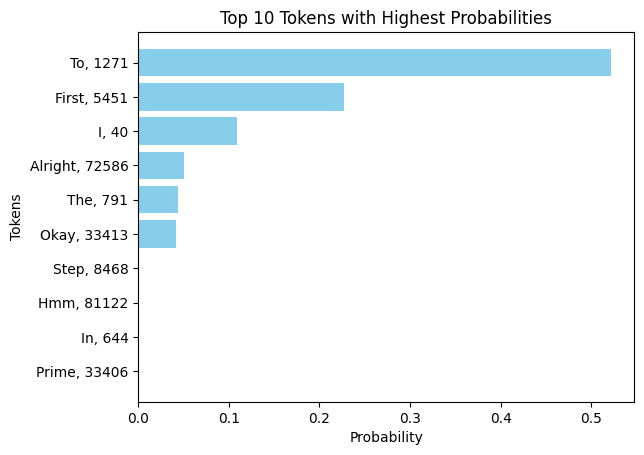

In [12]:
# Assuming `probs` is a tensor of probabilities and `model.tokenizer` is defined
topk = 10  # Number of top tokens to visualize
topk_probs, topk_indices = probs.topk(topk)  # Get top-k probabilities and their indices

# Decode the token indices to get the corresponding tokens
topk_tokens = [f"{model.tokenizer.decode([idx])}, {idx}" for idx in topk_indices]

# Convert tensors to numpy arrays for visualization
topk_probs = topk_probs.cpu().detach().numpy()
topk_indices = topk_indices.cpu().detach().numpy()

# Plot the bar chart
import matplotlib.pyplot as plt

plt.barh(topk_tokens, topk_probs, color='skyblue')
plt.xlabel('Probability')
plt.ylabel('Tokens')
plt.title('Top 10 Tokens with Highest Probabilities')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest probability at the top
plt.show()

### creating answering metric 

we'll take a set of different reasoning prompts 

In [13]:
import random
import re

def sample_prompts(filepath="mds/reasoning-prompts.md", n=1, seed=None):
    """
    Samples n prompts randomly from a markdown file.

    Args:
        filepath (str): Path to the markdown file.
        n (int): Number of prompts to sample.
        seed (int, optional): Random seed for reproducibility.

    Returns:
        List of sampled prompts as strings (without leading numbers).
    """
    if seed is not None:
        random.seed(seed)

    with open(filepath, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract prompts: assume prompts are numbered like '1. ', '2. ', etc.
    prompts = []
    for line in lines:
        line = line.strip()
        if line and line[0].isdigit():
            # Remove the leading number and period using regex
            prompt = re.sub(r'^\d+\.\s*', '', line)
            prompts.append(prompt)

    if n > len(prompts):
        raise ValueError(f"Requested {n} prompts, but only {len(prompts)} available.")

    return random.sample(prompts, n)


In [14]:
samples = sample_prompts(filepath="mds/reasoning-prompts.md", n=50, seed=1)

In [15]:
tot_probs = None

for sample in samples:
    print(sample)
    chat = [
        {"role": "user", "content": sample},
    ]

    output = model(model.tokenizer.apply_chat_template(chat, add_generation_prompt=True, tokenize=False), return_type='logits')
    probs = output[0, -1, :].softmax(dim=-1)
    if tot_probs is None:
        tot_probs = probs
    else:
        tot_probs += probs
tot_probs /= len(samples)
topk = 10  # Number of top tokens to visualize



If a store sells 3 pens for $2.40, how much will 7 pens cost?


Which country was the first to industrialize?
What is the main function of the liver?
What is the process of converting light energy into chemical energy in plants?
What is the difference between an acid and a base?
If 20% of a number is 35, what is the number?
What is the antonym of "brave"?
If 2x + 3y = 12 and x = 3, what is y?
Who was the first president of the United States?
What causes the seasons on Earth?
What does the idiom "beat around the bush" mean?
What is the difference between "lay" and "lie"?
What event marked the beginning of the Great Depression?
Identify the alliteration in: "Peter Piper picked a peck of pickled peppers."
What is the smallest unit of an element?
What is the median of the numbers: 12, 7, 15, 9, 21?
If the ratio of boys to girls in a class is 3:5 and there are 24 students total, how many boys are in the class?
Which civilization built the pyramids in Egypt?
What is the sum of the first 10 integers?
What causes the phases of the Moon?
What is the law of 

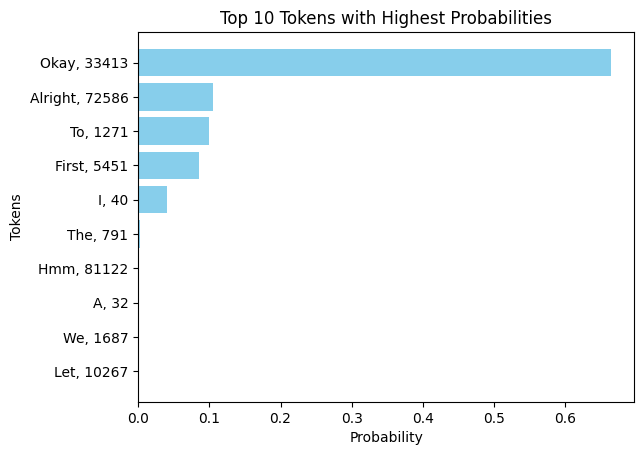

In [16]:
# now plots the topk tokens
topk_probs, topk_indices = tot_probs.topk(topk)  # Get top-k probabilities and their indices
# Decode the token indices to get the corresponding tokens
topk_tokens = [f"{model.tokenizer.decode([idx])}, {idx}" for idx in topk_indices]
# Convert tensors to numpy arrays for visualization
topk_probs = topk_probs.cpu().detach().numpy()
topk_indices = topk_indices.cpu().detach().numpy()
# Plot the bar chart
plt.barh(topk_tokens, topk_probs, color='skyblue')
plt.xlabel('Probability')
plt.ylabel('Tokens')
plt.title('Top 10 Tokens with Highest Probabilities')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest probability at the top
plt.show()

now we'll take prompts and generate up to the top think token

# Note 

it looks like the style of reasoning vs answering is very prompt specific 

why don't I just examine the style of a specific prompt, and construct a prompt specific metric 

In [39]:
import torch
import torch.nn.functional as F
from transformer_lens import HookedTransformer
from typing import List, Dict

def js_distance(p: torch.Tensor, q: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    """
    Jensen-Shannon distance between p and q.
    Returns sqrt(0.5*KL(p||m) + 0.5*KL(q||m)), where m = 0.5*(p+q).
    """
    m = 0.5 * (p + q)
    kl_pm = torch.sum(p * (torch.log(p + eps) - torch.log(m + eps)))
    kl_qm = torch.sum(q * (torch.log(q + eps) - torch.log(m + eps)))
    jsd = 0.5 * (kl_pm + kl_qm)
    return torch.sqrt(jsd)

class ReasoningAnsweringComparator:
    def __init__(
        self,
        model: HookedTransformer,
        prompt: str,
        eos_token: str = "</think>"
    ):
        """
        Build reference distributions p_ref_think and p_ref_ans from `model` on `prompt`.
        """
        self.tokenizer = model.tokenizer
        self.eos_token = eos_token
        self.eos_id = self.tokenizer.encode(eos_token)[-1]

        # wrap prompt in chat format
        chat = [{"role": "user", "content": prompt}]

        # 1) THINK prefix
        self.think_prefix = self.tokenizer.apply_chat_template(
            chat, add_generation_prompt=True, tokenize=False
        )

        # 2) ANSWER prefix (greedy to </think>)
        self.answer_prefix = self._greedy_think_generation(model, self.think_prefix)
        self.answer_prefix += '\n\n'

        # 3) stash full-vocabulary reference distributions
        self.p_ref_think = self._get_full_dist(model, self.think_prefix)
        self.p_ref_ans   = self._get_full_dist(model, self.answer_prefix)

    def _greedy_think_generation(self, model: HookedTransformer, prefix: str) -> str:
        out = model.generate(
            prefix,
            max_new_tokens=500,
            do_sample=False,
            eos_token_id=self.eos_id
        )
        assert out.endswith(self.eos_token)
        return out

    def _get_full_dist(self, model: HookedTransformer, prefix: str) -> torch.Tensor:
        """
        Returns a 1-D tensor of next-token probabilities for the entire vocab.
        """
        logits = model(prefix, return_type="logits")  # [1, L, V]
        last   = logits[0, -1]                        # [V]
        return F.softmax(last, dim=-1)

    def compare_model(
        self,
        other_model: HookedTransformer,
        mode: str = "think",
        eps: float = 1e-12
    ) -> Dict[str, float]:
        """
        Compute JS-distance for the chosen region (think or answer), then
        build a mode_score = (d_think - d_ans)/(d_think + d_ans) in [-1,1],
        plus softmax probabilities.
        """
        if mode == "think":
            cur_prefix = self.think_prefix
        elif mode == "answer":
            cur_prefix = self.answer_prefix
        else:
            raise ValueError("mode must be 'think' or 'answer'")

        # model's output distribution for this prefix
        q = self._get_full_dist(other_model, cur_prefix)

        # distances to each reference distribution
        d_think = js_distance(self.p_ref_think, q, eps)
        d_ans   = js_distance(self.p_ref_ans,   q, eps)

        # normalized mode score in [-1,1]
        mode_score = ((d_think - d_ans) / (d_think + d_ans + eps)).item()

        # probabilistic interpretation via softmax(-distance)
        logits = torch.tensor([-d_think, -d_ans])
        probs  = F.softmax(logits, dim=0)

        return {
            "JS_dist_think": d_think.item(),
            "JS_dist_ans":   d_ans.item(),
            "mode_score":    mode_score,
            "P_think":       probs[0].item(),
            "P_ans":         probs[1].item(),
        }


In [40]:
weight_vectors = np.load('layer_analyses/combined_delta_vectors.npy')

steering_vectors = [None]+[-torch.tensor(w[None, :], device='cuda:0') for w in weight_vectors]

In [41]:
def produce_layer_resid_pre_steering_hook(steering_vector, scale=1.0):
    def resid_pre_hook(
        value,
        hook
    ):
        value[:, -1, :] += steering_vector.to(value)*scale
        return value

    return resid_pre_hook


def set_steering_vectors(
    model,
    target_layer_indices,
    weight_vectors,
    scale=1.0,
):
    """ 
    Adds steering vectors to the model at the specified layer indices.
    add only to resid_pre 

    Args:
        model (HookedTransformer): The model to modify.
        target_layer_indices (list of int): The layer indices to add steering vectors to.
        weight_vectors (np.ndarray): The steering vectors to add.
        scale (float): The scaling factor for the steering vectors.
    """
    model.reset_hooks()
    for block_idx, block in enumerate(model.blocks):
        if block_idx in target_layer_indices:
            # Get the steering vector for this block
            steering_vector = weight_vectors[block_idx]
            # Create the hook function
            resid_pre_hook = produce_layer_resid_pre_steering_hook(steering_vector, scale)
            # Add the hook to the model
            model.add_hook(
                utils.get_act_name('resid_pre', block_idx),
                resid_pre_hook
            )

In [42]:
model.reset_hooks()

metric_comparator = ReasoningAnsweringComparator(model, "What is the fifth prime?")

  0%|          | 0/500 [00:00<?, ?it/s]

 16%|█▌        | 78/500 [00:05<00:31, 13.53it/s]


In [43]:
set_steering_vectors(
    model,
    target_layer_indices=range(10, 32),
    weight_vectors=steering_vectors,
    scale=0,
)
model.reset_hooks()

metric0 = metric_comparator.compare_model(
    model, 
    mode="think"
)

set_steering_vectors(
    model,
    target_layer_indices=range(1, 32),
    weight_vectors=steering_vectors,
    scale=.6,
)

metric08 = metric_comparator.compare_model(
    model, 
    mode="think"
)



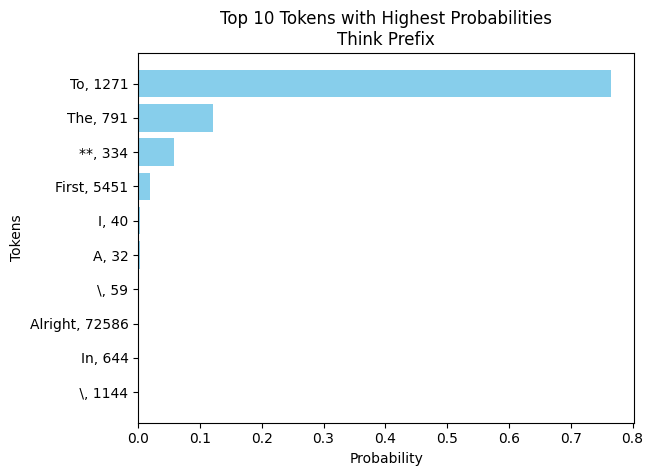

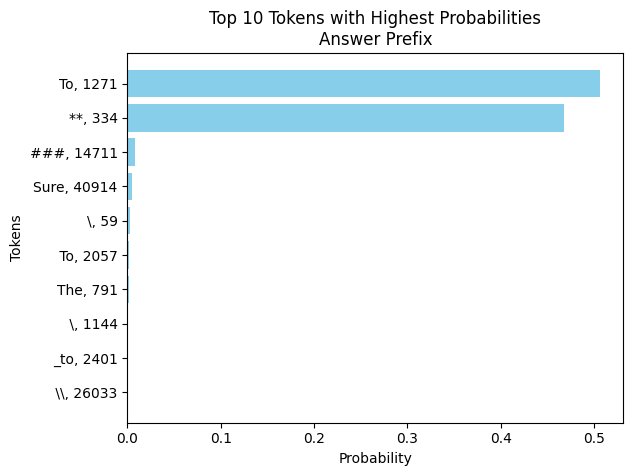

In [44]:
def plot_topk_probs_and_tokens(model, string, plot_title):
    logits = model(string, return_type='logits')
    probs = logits[0, -1, :].softmax(dim=-1)

    # Assuming `probs` is a tensor of probabilities and `model.tokenizer` is defined
    topk = 10  # Number of top tokens to visualize
    topk_probs, topk_indices = probs.topk(topk)  # Get top-k probabilities and their indices

    # Decode the token indices to get the corresponding tokens
    topk_tokens = [f"{model.tokenizer.decode([idx])}, {idx}" for idx in topk_indices]

    # Convert tensors to numpy arrays for visualization
    topk_probs = topk_probs.cpu().detach().numpy()
    topk_indices = topk_indices.cpu().detach().numpy()

    # Plot the bar chart
    plt.barh(topk_tokens, topk_probs, color='skyblue')
    plt.xlabel('Probability')
    plt.ylabel('Tokens')
    plt.title(f'Top 10 Tokens with Highest Probabilities\n{plot_title}')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest probability at the top
    plt.show()

plot_topk_probs_and_tokens(model, metric_comparator.think_prefix, "Think Prefix")
plot_topk_probs_and_tokens( 
    model, 
    metric_comparator.answer_prefix,
    "Answer Prefix"
)



In [45]:
metric08

{'JS_dist_think': 0.424529105424881,
 'JS_dist_ans': 0.3240877687931061,
 'mode_score': 0.13416920602321625,
 'P_think': 0.47491076588630676,
 'P_ans': 0.5250892639160156}

In [46]:
metric0

{'JS_dist_think': 0.0,
 'JS_dist_ans': 0.5311553478240967,
 'mode_score': -1.0,
 'P_think': 0.629752516746521,
 'P_ans': 0.3702474534511566}

# How do the later steering vectors align with tokens 

Text(0.5, 1.0, 'Top 15 Tokens with Highest overlap with steering vector')

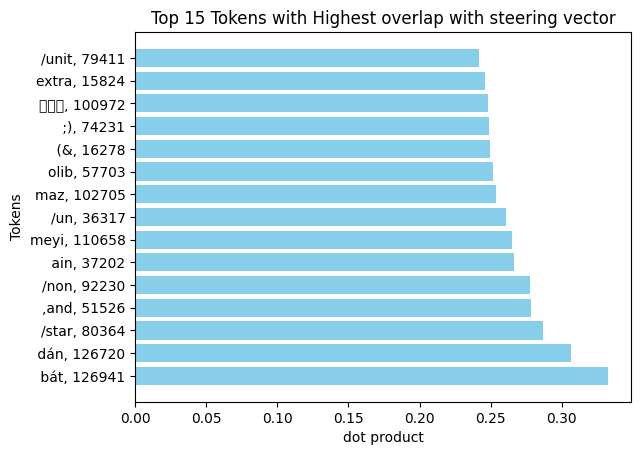

In [55]:
# plot the topk tokens which align with the final steering vector 

final_steering_vector = steering_vectors[-1]
unembed_weights = model.W_U

steering_dots = (final_steering_vector@unembed_weights)[0] 

# now plot the topk tokens
topk = 15  # Number of top tokens to visualize
topk_probs, topk_indices = steering_dots.topk(topk)  # Get top-k probabilities and their indices
# Decode the token indices to get the corresponding tokens
topk_tokens = [f"{model.to_string([idx])}, {idx}" for idx in topk_indices]
# Convert tensors to numpy arrays for visualization
topk_probs = topk_probs.cpu().detach().numpy()
topk_indices = topk_indices.cpu().detach().numpy()
# Plot the bar chart
plt.barh(topk_tokens, topk_probs, color='skyblue')
plt.xlabel('dot product')
plt.ylabel('Tokens')
plt.title(f'Top {topk} Tokens with Highest overlap with steering vector')

In [68]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-31): 32 x TransformerBlock(
      (ln1): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out)

Text(0.5, 1.0, 'Top 15 Tokens with Lowest overlap with steering vector')

/root/mech_interp_research/venv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/root/mech_interp_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


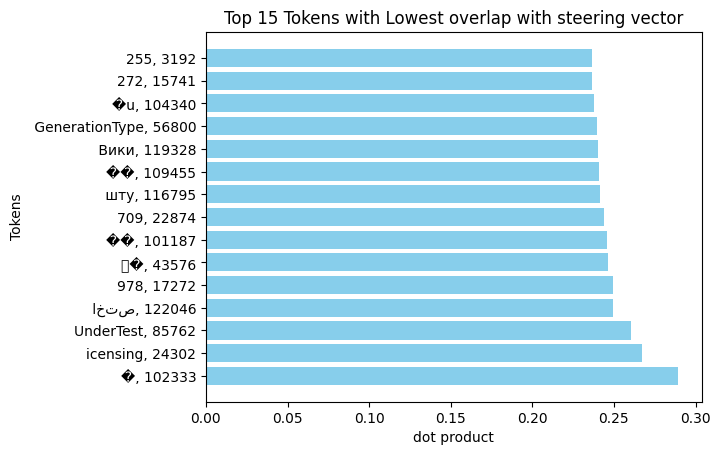

In [65]:
final_steering_vector = steering_vectors[-1]
unembed_weights = model.W_U

steering_dots = -(final_steering_vector@unembed_weights)[0] 

# now plot the topk tokens
topk = 15  # Number of top tokens to visualize
topk_probs, topk_indices = steering_dots.topk(topk)  # Get top-k probabilities and their indices
# Decode the token indices to get the corresponding tokens
topk_tokens = [f"{model.to_string([idx])}, {idx}" for idx in topk_indices]
# Convert tensors to numpy arrays for visualization
topk_probs = topk_probs.cpu().detach().numpy()
topk_indices = topk_indices.cpu().detach().numpy()
# Plot the bar chart
plt.barh(topk_tokens, topk_probs, color='skyblue')
plt.xlabel('dot product')
plt.ylabel('Tokens')
plt.title(f'Top {topk} Tokens with Lowest overlap with steering vector')

### Question 

Suppose I inject the steering vector at different layers
What has the largest influence 

### Question 

Where does 334 turn on here? 

Let's do a logit lens to find out 





In [108]:
import torch
import torch.nn.functional as F

def layerwise_logit_lens_with_probs(
    model: HookedTransformer,
    token: str | int,
    device: str = None
):
    """
    For a single token, capture h after embed + each block, apply final ln,
    compute full-vocab logits via the unembed, softmax them, and plot
    P(token) at each layer.
    """
    # ————— Device & token prep —————
    if device:
        model = model.to(device)
    else:
        device = next(model.parameters()).device

    if isinstance(token, str):
        toks = model.to_tokens(token).to(device)
        token_id = toks[0, 0].item()
    else:
        token_id = int(token)
        toks = torch.tensor([[token_id]], device=device)

    # ————— Hook fn to grab each [1,1,d_model] → store [d_model] —————
    activations = []
    def save_act(act, hook):
        activations.append(act[0,0].detach())

    # build list of (hook_name, fn)
    fwd_hooks = [("hook_embed", save_act)]
    n_layers = model.cfg.n_layers
    for i in range(n_layers):
        fwd_hooks.append((f"blocks.{i}.hook_resid_post", save_act))

    # run forward once
    _ = model.run_with_hooks(toks, fwd_hooks=fwd_hooks, return_type=None)

    # ————— Grab unembed weight & bias in (vocab, d_model) form —————
    if hasattr(model.unembed, "weight"):
        W = model.unembed.weight           # (vocab, d_model)
        b = model.unembed.bias             # (vocab,)
    else:
        # transformer_lens sometimes stores W_U, b_U
        W = model.unembed.W_U.t()          # (vocab, d_model)
        b = model.unembed.b_U              # (vocab,)

    # move W, b to CPU for ease
    W, b = W.cpu(), b.cpu()

    # ————— Compute P(token) at each layer —————
    probs_at_layer = []
    for h in activations:
        # h is [d_model] on CPU
        # apply final ln: needs [1,1,d_model]
        h_in = h.unsqueeze(0).unsqueeze(0).to(device)
        with torch.no_grad():
            h_norm = model.ln_final(h_in)[0,0].cpu()   # back to [d_model]
        # logits over vocab:
        logits = W @ h_norm                          # [vocab]
        logits = logits + b
        p = F.softmax(logits, dim=0)[token_id].item()
        probs_at_layer.append(p)

    # ————— Plot the probability curve —————
    xs = list(range(len(probs_at_layer)))  # 0=embed, 1..n_layers=after each block
    plt.figure(figsize=(8,4))
    plt.plot(xs, probs_at_layer, marker='o')
    #plt.yscale('log')
    plt.xlabel(f"Layer (0=embed, 1–{n_layers}=after block)")
    plt.ylabel(f"P(token_id={token_id})")
    plt.title(f"Layerwise Softmax Probability for token {token_id}")
    plt.grid(True)
    plt.show()


In [109]:
model.unembed.W_U

Parameter containing:
tensor([[ 0.0074, -0.0063,  0.0141,  ..., -0.0033, -0.0034, -0.0033],
        [ 0.0073,  0.0035,  0.0064,  ...,  0.0031,  0.0031,  0.0031],
        [ 0.0096,  0.0189,  0.0152,  ...,  0.0029,  0.0029,  0.0029],
        ...,
        [ 0.0105, -0.0029,  0.0034,  ...,  0.0010,  0.0010,  0.0010],
        [-0.0211,  0.0059, -0.0103,  ...,  0.0080,  0.0080,  0.0080],
        [-0.0141, -0.0030, -0.0162,  ...,  0.0085,  0.0085,  0.0085]],
       device='cuda:0', requires_grad=True)

In [110]:
model.W_U.shape

torch.Size([4096, 128256])

Moving model to device:  cuda:0


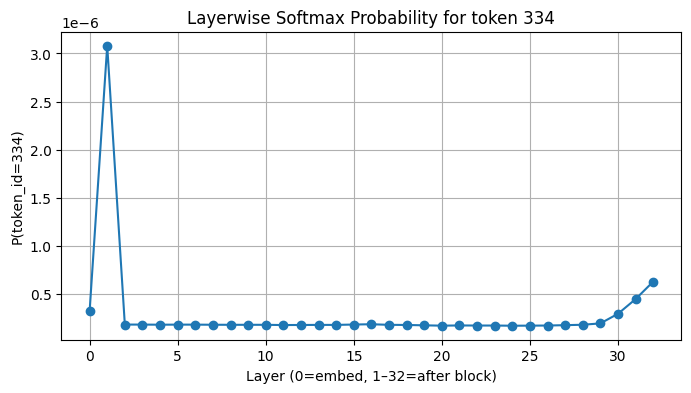

In [111]:
model.reset_hooks()

layerwise_logit_lens_with_probs(model, 334, device='cuda:0')

Moving model to device:  cuda:0


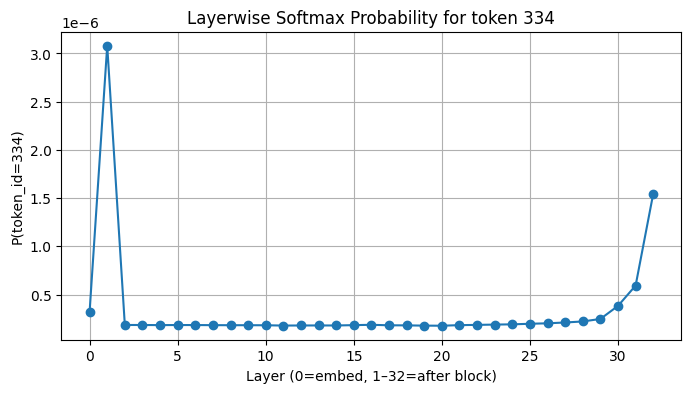

 18%|█▊        | 37/200 [00:02<00:12, 13.34it/s]


'<｜User｜>What is the fifth prime?<｜Assistant｜><think>\n**Solution:**\nTo determine the fifth prime number, we start by listing the natural numbers and identifying the prime numbers within them. A prime number is a natural number greater than \\\\'

In [112]:
set_steering_vectors(
    model,
    target_layer_indices=range(10,32),
    weight_vectors=steering_vectors,
    scale=.8,
)

layerwise_logit_lens_with_probs(model, 334, device='cuda:0')

model.generate(
    metric_comparator.think_prefix,
    max_new_tokens=200,
    do_sample=False,
)

Let's do head attribution

the way we'll do this is by swapping the activated heads between two 

In [113]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-31): 32 x TransformerBlock(
      (ln1): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out)

In [114]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer

def head_patch_heatmap(
    model: HookedTransformer,
    str1: str,
    str2: str,
    token_id: int,
    device: str = None
):
    """
    For each attention head in each layer, patch its z-output from str2
    into the evaluation of str1, record P(token_id), and display a heatmap.
    """
    # ——— Prep device + tokenize ———
    if device:
        model = model.to(device)
    else:
        device = next(model.parameters()).device

    toks1 = model.to_tokens(str1).to(device)   # [1, L1]
    toks2 = model.to_tokens(str2).to(device)   # [1, L2]
    n_layers = model.cfg.n_layers

    # ——— 1) Capture all head z's from string 2 ———
    # will hold: z2[layer] = Tensor of shape [1, L2, head_dim, n_heads]
    z2 = {}
    def make_save_z(layer_idx):
        def save_z(act, hook):
            # act shape: [1, L2, head_dim, n_heads]
            z2[layer_idx] = act.detach().cpu()
        return save_z

    hooks = []
    for layer in range(n_layers):
        hooks.append((f"blocks.{layer}.attn.hook_z", make_save_z(layer)))
    # run once
    _ = model.run_with_hooks(toks2, fwd_hooks=hooks, return_type=None)

    # Extract dims from layer 0:
    head_dim, n_heads = z2[0].shape[2], z2[0].shape[3]
    L1, L2 = toks1.shape[1], toks2.shape[1]
    pos1, pos2 = L1-1, L2-1  # patch only final token’s head-output

    # ——— Helper to compute P(token_id) given a single patch hook ———
    final_rep = {}
    def save_final(act, hook):
        # act: [1, L1, d_model]
        final_rep["h"] = act[0, pos1].detach().cpu()

    def patch_and_run(layer_idx, head_idx):
        # 1) define patch hook
        def patch_z(act, hook):
            # act: [1, L1, head_dim, n_heads]
            patched = act.clone()
            patched[0, pos1, :, head_idx] = z2[layer_idx][0, pos2, :, head_idx]
            return patched

        fwd_hooks = [
            (f"blocks.{layer_idx}.attn.hook_z", patch_z),
            (f"blocks.{n_layers-1}.hook_resid_post", save_final)
        ]
        # run
        _ = model.run_with_hooks(toks1, fwd_hooks=fwd_hooks, return_type=None)

        # compute P(token_id)
        h = final_rep["h"].unsqueeze(0).unsqueeze(0).to(device)
        with torch.no_grad():
            hn = model.ln_final(h)[0,0].cpu()    # [d_model]
        # get unembed
        if hasattr(model.unembed, "weight"):
            W = model.unembed.weight.cpu()
            b = model.unembed.bias.cpu()
        else:
            W = model.unembed.W_U.t().cpu()
            b = model.unembed.b_U.cpu()
        logits = W @ hn + b                  # [vocab]
        return F.softmax(logits, dim=0)[token_id].item()

    # ——— Baseline (no patch) ———
    # Capture final state
    final_rep.clear()
    _ = model.run_with_hooks(
        toks1,
        fwd_hooks=[(f"blocks.{n_layers-1}.hook_resid_post", save_final)],
        return_type=None
    )
    h0 = final_rep["h"].unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        hn0 = model.ln_final(h0)[0,0].cpu()
    if hasattr(model.unembed, "weight"):
        W0, b0 = model.unembed.weight.cpu(), model.unembed.bias.cpu()
    else:
        W0, b0 = model.unembed.W_U.t().cpu(), model.unembed.b_U.cpu()
    log0 = W0 @ hn0 + b0
    baseline = F.softmax(log0, dim=0)[token_id].item()

    # ——— 2) Loop over all heads & collect probs ———
    heat = torch.zeros(n_layers, n_heads)
    for i in range(n_layers):
        for j in range(n_heads):
            heat[i, j] = patch_and_run(i, j)

    # ——— 3) Plot heatmap ———
    plt.figure(figsize=(12, 6))
    im = plt.imshow(heat, aspect='auto', origin='lower')
    plt.colorbar(im, label=f"P(token={token_id})")
    plt.xlabel("Head index")
    plt.ylabel("Layer index")
    plt.title(
        f"Baseline P={baseline:.4f} → Patched P(token={token_id})\n"
        f"each row=layer, each col=head"
    )
    plt.show()


In [ ]:
head_patch_heatmap(
    model,
    str1=metric_comparator.think_prefix,
    str2=metric_comparator.answer_prefix,
    token_id=334,
    device='cuda:0'
)

Moving model to device:  cuda:0


In [106]:
set_steering_vectors(
    model,
    target_layer_indices=range(1, 32),
    weight_vectors=steering_vectors,
    scale=.6,
)

metric08 = metric_comparator.compare_model(
    model, 
    mode="think"
)
metric08

{'JS_dist_think': 0.424529105424881,
 'JS_dist_ans': 0.3240877687931061,
 'mode_score': 0.13416920602321625,
 'P_think': 0.47491076588630676,
 'P_ans': 0.5250892639160156}

In [60]:
model.to_tokens("**")

tensor([[128000,    334]], device='cuda:0')

tensor([0.0780], device='cuda:0')

In [48]:
topk_indices

tensor([[126941, 126720,  80364,  51526,  92230,  37202, 110658,  36317, 102705,
          57703]], device='cuda:0')

In [28]:
chat = [
  {"role": "user", "content": "What's the fifth prime?"},
]

In [29]:
model.tokenizer.apply_chat_template(chat, add_generation_prompt=True, tokenize=False)

"<｜begin▁of▁sentence｜><｜User｜>What's the fifth prime?<｜Assistant｜><think>\n"

In [30]:
test_output = model.generate(
    model.tokenizer.apply_chat_template(chat, add_generation_prompt=True, tokenize=False),
    max_new_tokens=256,
    do_sample=False,
    eos_token_id=128014
)

  0%|          | 0/256 [00:00<?, ?it/s]

100%|██████████| 256/256 [00:18<00:00, 13.53it/s]


In [31]:
print(test_output)

<｜User｜>What's the fifth prime?<｜Assistant｜><think>
To determine the fifth prime number, we start by listing the prime numbers in sequence. A prime number is a natural number greater than 1 that has no positive divisors other than 1 and itself. 

1. **2** is the first prime number.
2. **3** is the second prime number.
3. **5** is the third prime number.
4. **7** is the fourth prime number.
5. **11** is the fifth prime number.

Thus, the fifth prime number is 11.
\boxed{11}
://://"
\boxed{11}
\"
"
\]
\boxed{11}
\"
\"
\]

\"
\boxed{11}
\"
\"

\"
\boxed{11}
\"

\"
\boxed{11}
\"

\"
\boxed{11}
\"

\"
\boxed{11}
\"

\"
\boxed{11}
\"

\"
\boxed{11}
\"

\"
\boxed{11}
\"

\"
\boxed{11}
\"

\"
\boxed{11}
\"

\"
\boxed{11}
\"

\"
\boxed{11}
\"

\"
\boxed{11


In [32]:
model.to_tokens("</think>")

tensor([[128000, 128014]], device='cuda:0')

In [33]:
model.tokenizer.apply_chat_template(chat, add_generation_prompt=True, tokenize=False)

"<｜begin▁of▁sentence｜><｜User｜>What's the fifth prime?<｜Assistant｜><think>\n"

In [34]:
props2 = output[0, -1, :].softmax(dim=-1)

In [35]:
type(props2)

torch.Tensor

In [36]:
props2.topk(10)

torch.return_types.topk(
values=tensor([5.1210e-01, 2.5772e-01, 1.0982e-01, 7.5115e-02, 2.2997e-02, 9.0958e-03,
        5.1384e-03, 8.5943e-04, 7.4983e-04, 5.0942e-04], device='cuda:0'),
indices=tensor([33413, 72586,  1271,  5451,    40, 81122,   791, 10267,    32, 11839],
       device='cuda:0'))

In [37]:
output

tensor([[[ 1.1601,  2.0860,  4.8631,  ..., -1.1549, -1.1549, -1.1549],
         [ 1.1601,  2.0860,  4.8631,  ..., -1.1549, -1.1549, -1.1549],
         [ 7.2881,  2.2454,  1.0443,  ..., -3.8254, -3.8254, -3.8258],
         ...,
         [ 2.1971, -2.1198, -4.2101,  ...,  2.0578,  2.0576,  2.0580],
         [ 3.6799,  5.7603,  5.6633,  ..., -2.0983, -2.0983, -2.0980],
         [ 4.1453,  7.5314,  8.6311,  ..., -2.1035, -2.1038, -2.1036]]],
       device='cuda:0')

In [38]:
jhg

NameError: name 'jhg' is not defined

Note: 

to do this rigorously 

compute probabilities over N (16, 32 prompts)

and use the outputs over those 
this controls for different output probabilities between different prompts 

look at variance between prmopts to make sure that your metrics 



In [ ]:
pos_features = [[1271], [1271, 1505], [1271, 8417], [334, 37942, 25]]
neg_features = [[33413]]

In [ ]:
model.to_string(neg_features[0])

'Okay'

In [ ]:
for feat in pos_features:
    print(model.to_string(feat))

To
To find
To determine
**Solution:


write a function which takes in a list of lists of tokens 

promtp = "do this"

eg: 
pos_features = [
    [12,],
    [13, 128]
]

negative_feats = [...]

log_prob(pos_feats) - log_prob(prompt+neg_feats) 


appends each to the end of a prompt, and returns their

In [ ]:

def compute_feature_mode_metric(
    model: HookedTransformer,
    prompt: str,
    pos_features: list[list[int]],
    neg_features: list[list[int]],
):
    """
    Computes:
      - normalized probabilities for each feature sequence (sum to 1)
      - unnormalized log-scores for each
      - logit (log-odds) of producing any negative feature.
    Uses model.to_tokens() for tokenization.
    """
    device = model.cfg.device
    # 1) Tokenize prompt with the built-in hook
    #    (adds BOS if the model is configured to)
    input_ids = model.to_tokens(prompt).to(device)

    # 2) Score one feature sequence by accumulating log-probs
    def sequence_score(feature: list[int]) -> torch.Tensor:
        ctx = input_ids.clone()
        total_log_prob = torch.tensor(0.0, device=device)
        for tok in feature:
            # run the model on the current context
            logits, activations = model.run_with_cache(ctx) #turn off this 
            last_logits = logits[:, -1, :]  # [1, vocab_size]
            log_probs = torch.log_softmax(last_logits, dim=-1)
            total_log_prob = total_log_prob + log_probs[0, tok]
            # append the ground-truth token to the context
            ctx = torch.cat([ctx, torch.tensor([[tok]], device=device)], dim=1)
        return total_log_prob

    # 3) Compute scores for all features
    all_features = pos_features + neg_features
    scores = torch.stack([sequence_score(f) for f in all_features])  # (n+m,)

    # 4) Softmax to get normalized probabilities
    norm_probs = torch.softmax(scores, dim=0)                        # (n+m,)

    # 5) Sum up the negative-feature mass & compute logit
    num_pos   = len(pos_features)
    neg_prob  = norm_probs[num_pos:].sum()
    neg_logit = torch.log(neg_prob) - torch.log(1 - neg_prob)

    return norm_probs, scores, neg_logit




In [ ]:
pos_features = [[1271], [1271, 1505], [1271, 8417], [334, 37942, 25]]
neg_features = [[33413]]

for pf in pos_features:
    print(model.to_string(pf))

print("\n\n")

for nf in neg_features:
    print(model.to_string(nf))

To
To find
To determine
**Solution:



Okay


In [ ]:

prompt       = "<｜User｜>What is 8/4<｜Assistant｜><think>\n"
pos_features = [[1271], [1271, 1505], [1271, 8417], [334, 37942, 25]]
neg_features = [[33413]]

norm_probs, scores, neg_logit = compute_feature_mode_metric(
    model, prompt, pos_features, neg_features
)

print("Normalized probabilities:", norm_probs)
print("Unnormalized log-scores:", scores)
print("Negative-feature logit:", neg_logit)

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 44.34 GiB of which 24.81 MiB is free. Process 2410955 has 44.31 GiB memory in use. Of the allocated memory 43.97 GiB is allocated by PyTorch, and 32.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:

prompt       = "<｜User｜>What is 8/4<｜Assistant｜><think>\nOkay, I know 8/4=2\n</think>s"
pos_features = [[1271], [1271, 1505], [1271, 8417], [334, 37942, 25]]
neg_features = [[33413]]

norm_probs, scores, neg_logit = compute_feature_mode_metric(
    model, prompt, pos_features, neg_features
)

print("Normalized probabilities:", norm_probs)
print("Unnormalized log-scores:", scores)
print("Negative-feature logit:", neg_logit)